In [30]:
import numpy as np
import math
from scipy import integrate
import itertools as itr
from common.ffn.ffn_relu import ParametricReLUNet
from common.ffn.ffn_base import FFNGmetricLogging
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from enum import Enum

ExpCalcMethod = Enum('ExpCalcMethod', ['SCIPY', 'SAMPLE_AVG'])

***
##### Theoretical values
***
For calculation expressions check formulas (1) - (6) in init_distribution_recursion_ffn_tanh.ipynb

***
##### Case: theoretical values for 2-point train set; all α and β are from [1,2]. Input dim is 100, all layer widths are 100; number of layers is 40. Activation function is hyperbolic tangent.
***
Experiment and FFN parameters:

In [37]:
'''n0: # dimension of x
    nk: # dimension of hidden layers
    nl: # dimension of output layer
    ln: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,ln=500,500,500,100
nd=2

CONST_M1=2
CONST_M2=2

'''Cb and Cw constants'''
slope_plus, slope_minus=1.22474487139, 0.70710678118 #1,1 #math.sqrt(2), 0
#weights distribution variances are set as in (5.67)
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)
print("cb={}, cw={}".format(cb, cw))

'''Integration method settings'''
expCalcMethod = ExpCalcMethod.SAMPLE_AVG
CONST_EXP_SAMPLE_SIZE=1000000

'''experiments settings'''
experiments_number = 100#0


cb=0, cw=1.000000000006576


Initialising trainset:

In [33]:
LOAD_TRAINSET_FROM_TRAINSET_CSV=True

if LOAD_TRAINSET_FROM_TRAINSET_CSV == True:
    if nd > 1:
        train_set = np.loadtxt("data/train-set.csv", delimiter=",")[:,:nd]
    else:
        train_set = np.expand_dims(np.loadtxt("data/train-set.csv", delimiter=","), axis=1)
else:
    #train_set = np.random.normal(loc=0.0, scale=1.0, size=(n0, nd)).astype(np.float32)
    train_set, _ = make_classification(n_samples=n0, n_features=nd, n_informative=nd, n_redundant=0, scale=1.0) #max(10, int(n0*0.2))
    np.savetxt("data/train-set.csv", train_set, delimiter=",")
if nd > 1:
    print(np.cov(train_set[:,0],train_set[:,1]))


[[1.56507594 0.25406747]
 [0.25406747 1.68811393]]


In [63]:
'''
matrix_GG_top = np.zeros((ln, nd,nd))
matrix_GG_bottom = np.zeros_like(matrix_GG_top)
matrix_gg_top = np.zeros_like(matrix_GG_top)
matrix_gg_bottom = np.zeros_like(matrix_gg_top)
matrix_vv_top = np.zeros((ln,nd,nd,nd,nd))
matrix_vv_bottom = np.zeros_like(matrix_vv_top)

matrix_GG_only_top = np.zeros((ln, nd,nd))
matrix_GG_only_bottom = np.zeros_like(matrix_GG_only_top)
matrix_gg_only_top = np.zeros_like(matrix_GG_only_top)
matrix_gg_only_bottom = np.zeros_like(matrix_gg_only_top)
'''

'\nmatrix_GG_top = np.zeros((ln, nd,nd))\nmatrix_GG_bottom = np.zeros_like(matrix_GG_top)\nmatrix_gg_top = np.zeros_like(matrix_GG_top)\nmatrix_gg_bottom = np.zeros_like(matrix_gg_top)\nmatrix_vv_top = np.zeros((ln,nd,nd,nd,nd))\nmatrix_vv_bottom = np.zeros_like(matrix_vv_top)\n\nmatrix_GG_only_top = np.zeros((ln, nd,nd))\nmatrix_GG_only_bottom = np.zeros_like(matrix_GG_only_top)\nmatrix_gg_only_top = np.zeros_like(matrix_GG_only_top)\nmatrix_gg_only_bottom = np.zeros_like(matrix_gg_only_top)\n'

For calculation expressions of 1st layer preactivation check formulas (7) - (10) in init_distribution_recursion_ffn_tanh.ipynb

Preactivation on 2nd and subsequent layers $z^{(l)}$ is count by formulas (2)-(5)

In [35]:
import subprocess

#returned_value = subprocess.call("d:/Projects-my/ml/Ml-readinggroup/Roberts_Yaida/chapter5/jar/start.cmd", shell=True) #, capture_output=True, check=True
#print('returned value:', returned_value)

base = "d:/Projects-my/ml/Ml-readinggroup/Roberts_Yaida/chapter5/jar/tmp146/"

data = np.loadtxt(base+"upperg-bottom.csv", delimiter=',', unpack=True)
matrix_GG_bottom = np.reshape(data, (ln,nd,nd))
data = np.loadtxt(base+"upperg-top.csv", delimiter=',', unpack=True)
matrix_GG_top = np.reshape(data, (ln,nd,nd))

data = np.loadtxt(base+"lowerg-bottom.csv", delimiter=',', unpack=True)
matrix_gg_bottom = np.reshape(data, (ln,nd,nd))
data = np.loadtxt(base+"lowerg-top.csv", delimiter=',', unpack=True)
matrix_gg_top = np.reshape(data, (ln,nd,nd))

***
##### Observed values
***

In [38]:
#Callback
#To save each layer preactivation
z0_records = []
if (nd > 1):
    z1_records = []
#Only values for 1-st neuron of each layer is saved
def aggregarePreactivation(zn):
    exp0_records.append(zn[0])#,0
    if (nd > 1):
        exp1_records.append(zn[1])#,0

testNet = ParametricReLUNet(n0=n0,nk=nk,nl=nl,l=ln)
testNet.set_slopes(slope_plus, slope_minus)
testNet.register_on_forward_step_preactiv_callback(aggregarePreactivation)
testNet.set_log_level("info")
if (nd > 1):
    testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])
else:
    testNet.set_gmetric_recording_indices([(1,1)])

yy = np.zeros((experiments_number, nl, nd))
G00_records = []
if (nd > 1):
    G11_records = []
    G01_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    exp0_records = []
    if (nd > 1):
        exp1_records = []

    testNet.init_weights(cb, cw)
    res = testNet.forward(train_set)
    yy[experiment_number] = res
    G00_records.append(testNet.get_gmetric(1,1).copy())
    if (nd > 1):
        G11_records.append(testNet.get_gmetric(2,2).copy())
        G01_records.append(testNet.get_gmetric(1,2).copy())

    z0_records.append(exp0_records)
    if (nd > 1):
        z1_records.append(exp1_records)
    
    print('-', end='')

#Each layer preactivation result
z0records = np.asarray(z0_records)
if (nd > 1):
    z1records = np.asarray(z1_records)

FeedForwardNet created with n0=500, nk=500, nl=500, l=100, bias_on=False
----------------------------------------------------------------------------------------------------

In [40]:
avex_g = f"Average experimental G-values"
samplecov_z=f"Sample-covariance values"
theor_g=f"Theoretical G-values"
theor_g_main=f"Theoretical G-values, main term only"
ex_g=f"Experimental G-values"
lavernum="Layer number (0-based number)"
values_g="G-metric values"
valueslogabs_g="G-metric logarithmic absolute values"
valueslog_g="G-metric logarithmic values"

GRAPH_FRAME=300


In [41]:
#np.moveaxis(z0records, -1, 0).shape
#np.reshape(np.moveaxis(z0records, -1, 0), (100000, 100)).shape
#, (100, 100000)
z0records_tmp, z1records_tmp = z0records, z1records
z0records = np.reshape(np.moveaxis(z0records_tmp, -1, 0), (50000, 100))
z1records = np.reshape(np.moveaxis(z1records_tmp, -1, 0), (50000, 100))

Text(0.5, 0.98, 'Params: n0=500,nk=500,nl=500,ln=100,nd=2,cb=0,cw=1.000000000006576; relu params: slope_plus=1.22474487139,slope_minus=0.70710678118;experiments_number=100,CONST_M1=2,CONST_M2=2')

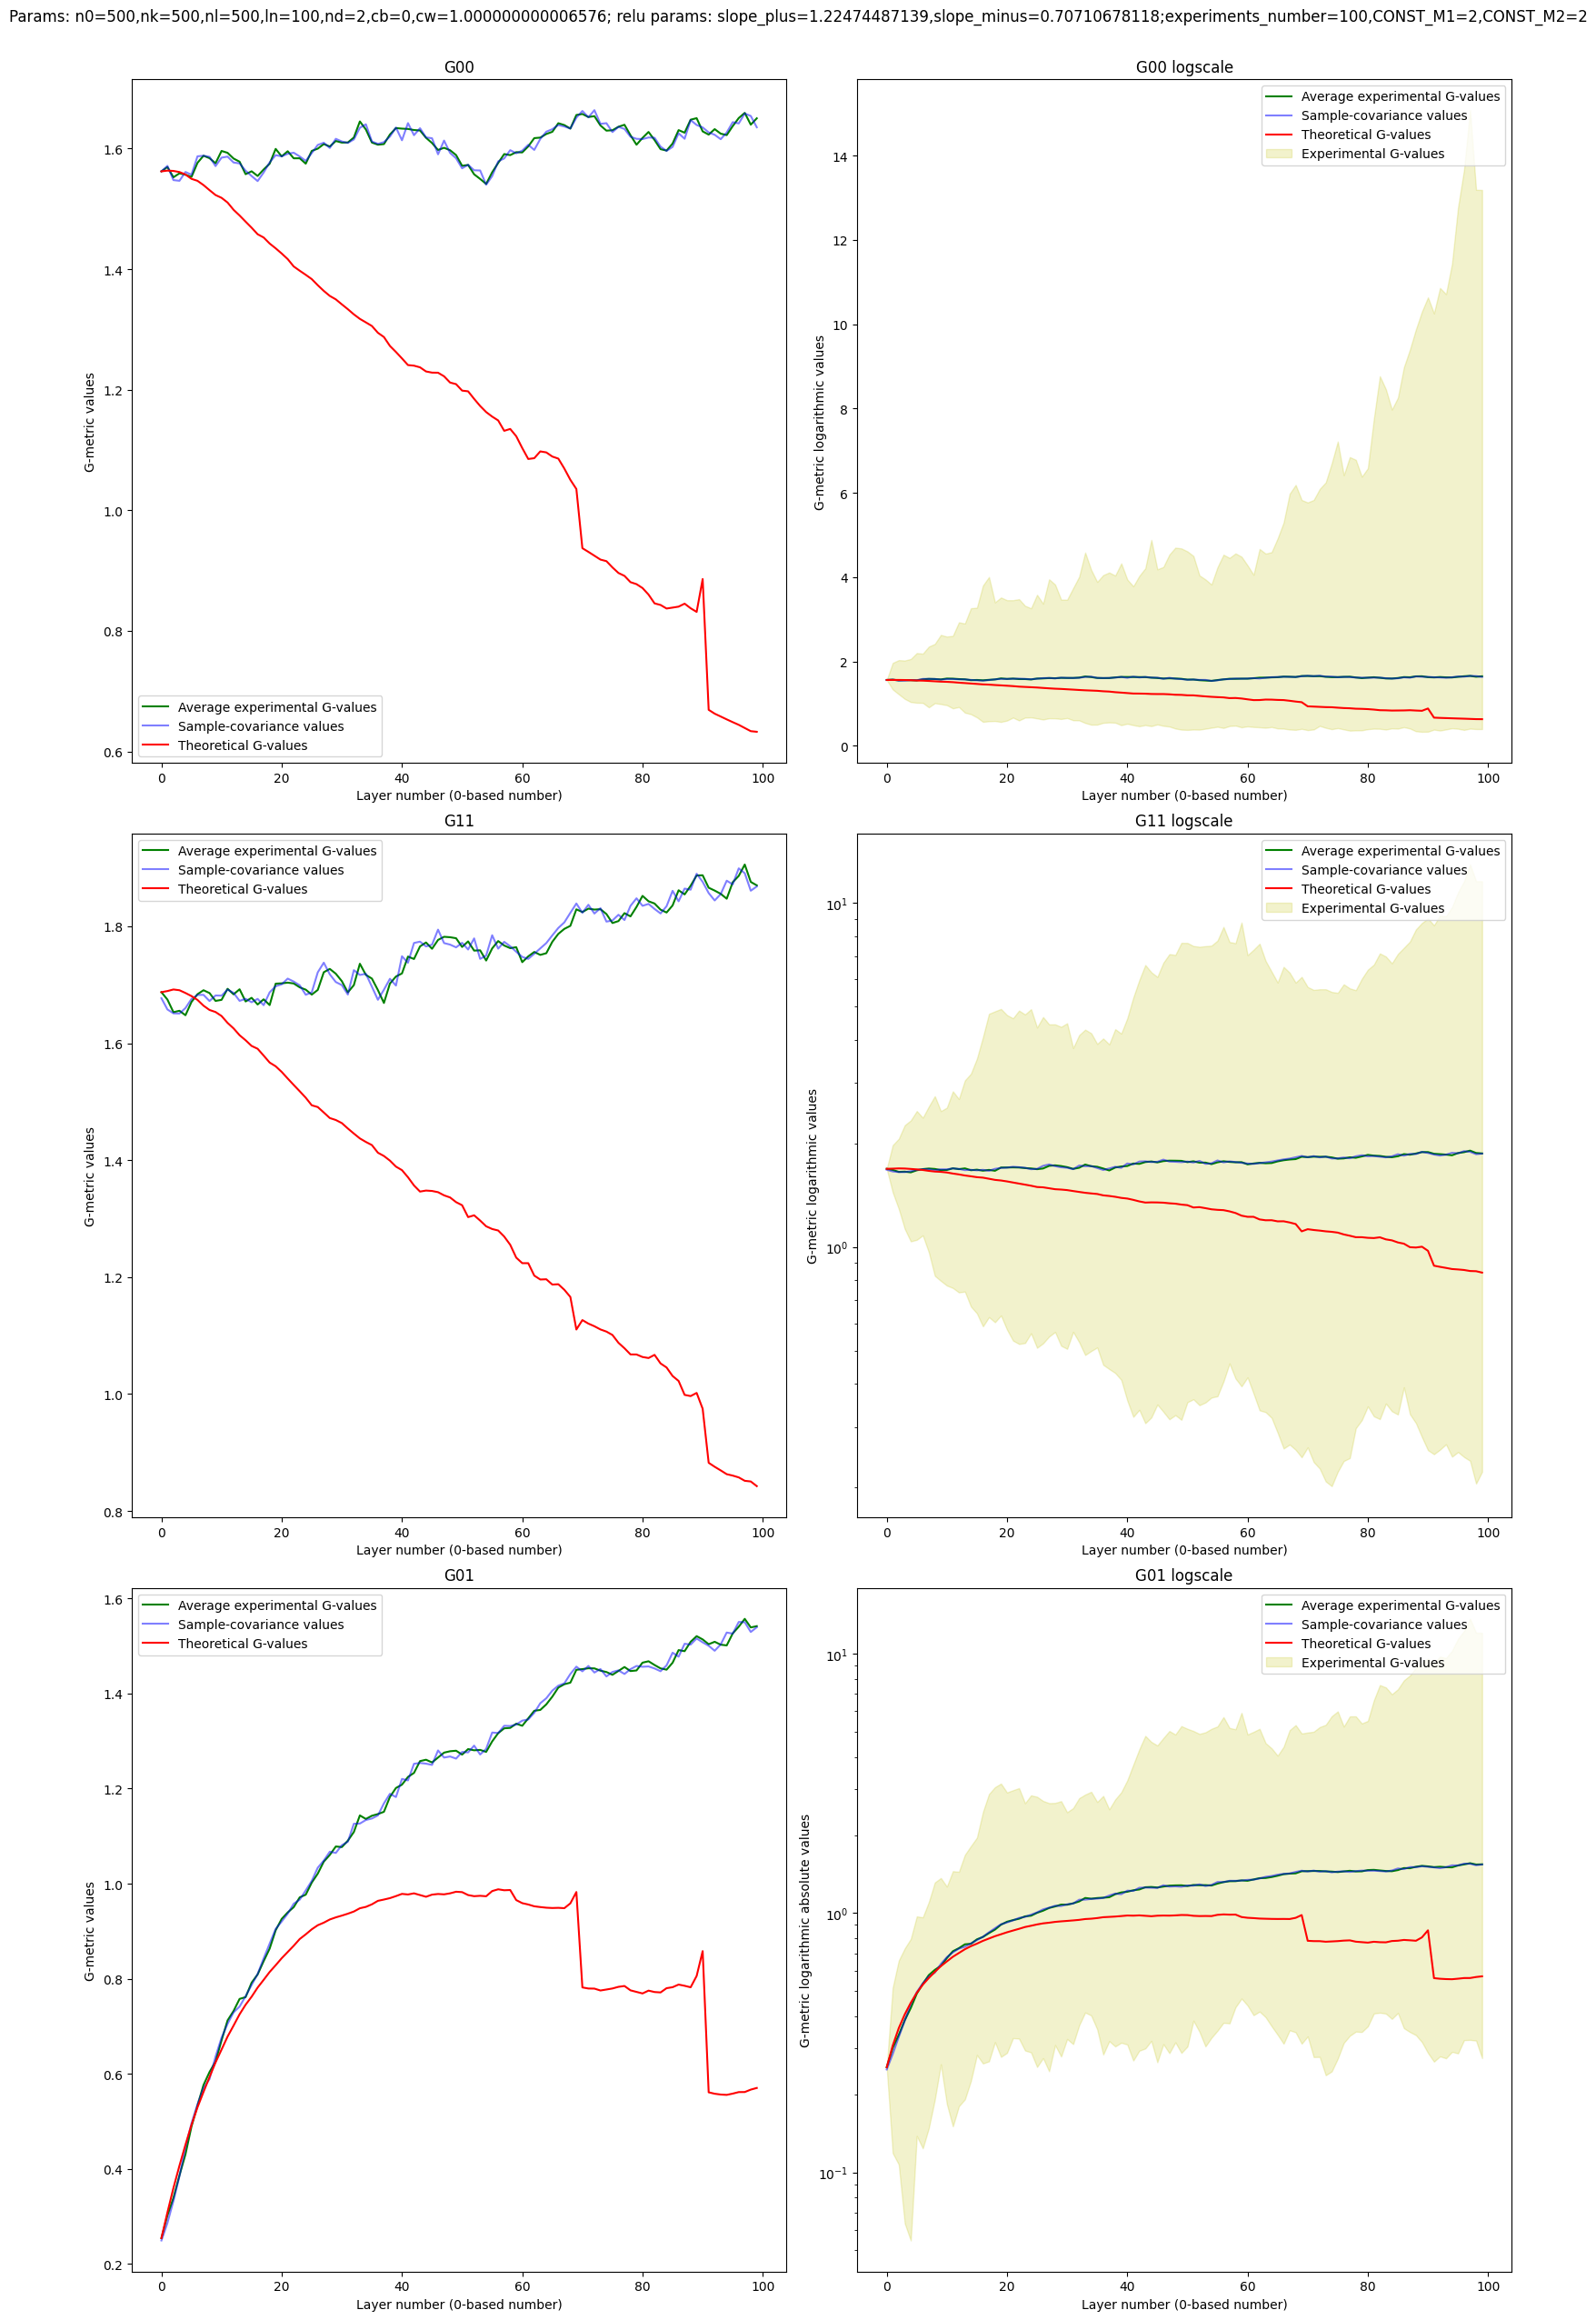

In [42]:
if (nd > 1):
    fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 26))
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

#for i, Gs in enumerate(G00_records):
#    ax1.plot(Gs, alpha=0.5, label=f"experiment {i}")

graphic_frame = min(GRAPH_FRAME, len(G00_records[0]))
G00_plot = np.asarray(G00_records)[:,0:graphic_frame]
cord_x = np.arange(0, len(G00_plot[0]))

G00_max = np.max(G00_plot, axis=0)
G00_min = np.min(G00_plot, axis=0)
G00_avg = np.average(G00_plot, axis=0)
G00_sample = [G00_avg[0]]
for xx in cord_x:
    G00_sample.append(np.cov(z0records[:,xx],z0records[:,xx])[0,1])

G00_sample = G00_sample[:100]

ax1.plot(G00_avg, color='g', label=avex_g)
ax1.plot(G00_sample, color='b', alpha=0.5, label=samplecov_z)
ax1.plot(matrix_GG_bottom[:graphic_frame,0,0], color='r', label=theor_g)
#ax1.plot(matrix_GG_only_bottom[:graphic_frame,0,0], color='m', alpha=0.25, label=theor_g_main)
#ax1.fill_between(x=cord_x, y1=G00_min, y2=G00_max, color='y', alpha=.2, label=ex_g)
ax1.set_xlabel(lavernum)
ax1.set_ylabel(values_g)
ax1.legend()
ax1.title.set_text("G00")

ax2.plot((G00_avg), color='g', label=avex_g)
ax2.plot((G00_sample), color='b', alpha=0.5, label=samplecov_z)
ax2.plot((matrix_GG_bottom[:graphic_frame,0,0]), color='r', label=theor_g)
#ax2.plot((matrix_GG_only_bottom[:graphic_frame,0,0]), color='m', alpha=0.25, label=theor_g_main)
ax2.fill_between(x=cord_x, y1=(G00_min), y2=(G00_max), color='y', alpha=.2, label=ex_g)
ax2.set_xlabel(lavernum)
ax2.set_ylabel(valueslog_g)
ax2.set_yscale("log")
ax2.legend()
ax2.title.set_text("G00 logscale")

if (nd > 1):
    graphic_frame = min(GRAPH_FRAME, len(G11_records[0]))
    G11_plot = np.asarray(G11_records)[:,0:graphic_frame]
    cord_x = np.arange(0, len(G11_plot[0]))

    G11_max = np.max(G11_plot, axis=0)
    G11_min = np.min(G11_plot, axis=0)
    G11_avg = np.average(G11_plot, axis=0)
    G11_sample = []
    for xx in cord_x:
        G11_sample.append(np.cov(z1records[:,xx],z1records[:,xx])[0,1])

    ax3.plot(cord_x, G11_avg, color='g', label=avex_g)
    ax3.plot(cord_x, G11_sample, color='b', alpha=0.5, label=samplecov_z)
    ax3.plot(cord_x, matrix_GG_bottom[:graphic_frame,1,1], color='r', label=theor_g)
    #ax3.plot(cord_x, matrix_GG_only_bottom[:graphic_frame,1,1], color='m', alpha=0.25, label=theor_g_main)
    #ax3.fill_between(x=cord_x, y1=G11_min, y2=G11_max, color='y', alpha=.2, label=ex_g)
    ax3.set_xlabel(lavernum)
    ax3.set_ylabel(values_g)
    ax3.legend()
    ax3.title.set_text("G11")

    ax4.plot(cord_x, (G11_avg), color='g', label=avex_g)
    ax4.plot(cord_x, (G11_sample), color='b', alpha=0.5, label=samplecov_z)
    ax4.plot(cord_x, (matrix_GG_bottom[:graphic_frame,1,1]), color='r', label=theor_g)
    #ax4.plot(cord_x, (matrix_GG_only_bottom[:graphic_frame,1,1]), color='m', alpha=0.25, label=theor_g_main)
    ax4.fill_between(x=cord_x, y1=(G11_min), y2=(G11_max), color='y', alpha=.2, label=ex_g)
    ax4.set_xlabel(lavernum)
    ax4.set_ylabel(valueslog_g)
    ax4.set_yscale("log")
    ax4.legend()
    ax4.title.set_text("G11 logscale")

    graphic_frame = min(GRAPH_FRAME, len(G01_records[0]))
    G01_plot = np.asarray(G01_records)[:,0:graphic_frame]
    cord_x = np.arange(0, len(G01_plot[0]))

    G01_max = np.max(G01_plot, axis=0)
    G01_min = np.min(G01_plot, axis=0)
    G01_avg = np.average(G01_plot, axis=0)
    cord_x = np.arange(0, len(G01_plot[0]))
    G01_sample = []
    for xx in cord_x:
        G01_sample.append(np.cov(z0records[:,xx],z1records[:,xx])[0,1])    

    ax5.plot(cord_x, G01_avg, color='g', label=avex_g)
    ax5.plot(cord_x, G01_sample, color='b', alpha=0.5, label=samplecov_z)
    ax5.plot(cord_x, matrix_GG_bottom[:graphic_frame,0,1], color='r', label=theor_g)
    #ax5.plot(cord_x, matrix_GG_only_bottom[:graphic_frame,0,1], color='m', alpha=0.25, label=theor_g_main)
    #ax5.fill_between(x=cord_x, y1=((G01_min)), y2=((G01_max)), color='y', alpha=.2, label=ex_g)
    ax5.set_xlabel(lavernum)
    ax5.set_ylabel(values_g)
    ax5.legend()
    ax5.title.set_text("G01")

    ax6.plot(cord_x, ((G01_avg)), color='g', label=avex_g)
    ax6.plot(cord_x, ((np.asarray(G01_sample))), color='b', alpha=0.5, label=samplecov_z)
    ax6.plot(cord_x, ((matrix_GG_bottom[:graphic_frame,0,1])), color='r', label=theor_g)
    #ax6.plot(cord_x, ((matrix_GG_only_bottom[:graphic_frame,0,1])), color='m', alpha=0.25, label=theor_g_main)
    ax6.fill_between(x=cord_x, y1=(G01_min), y2=(G01_max), color='y', alpha=.2, label=ex_g)
    ax6.set_xlabel(lavernum)
    ax6.set_ylabel(valueslogabs_g)
    ax6.set_yscale("log")
    ax6.legend()
    ax6.title.set_text("G01 logscale")

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Params: n0={n0},nk={nk},nl={nl},ln={ln},nd={nd},cb={cb},cw={cw}; \
relu params: slope_plus={slope_plus},slope_minus={slope_minus};experiments_number={experiments_number},\
CONST_M1={CONST_M1},CONST_M2={CONST_M2}")
#plt.show()

In [8]:
layer_zb = 0
gg_bottom = matrix_gg_bottom[layer_zb]
ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
GG_head = np.zeros((nd,nd))
ggg = calc_GG_integral(layer_zb,0,0,GG_head,ZZ_g)
print("integrate result:{}".format(ggg))


NameError: name 'calc_GG_integral' is not defined

In [ ]:
'''
pts = np.random.multivariate_normal([0, 0], gg_bottom, size=1000000)
buff = [aux.PReLUz(val[0])*aux.PReLUz(val[1]) for val in pts]
#buff = [val[0]*val[1] for val in pts]
print("average result:{}".format(np.average(buff)))
'''

'\npts = np.random.multivariate_normal([0, 0], gg_bottom, size=1000000)\nbuff = [aux.PReLUz(val[0])*aux.PReLUz(val[1]) for val in pts]\n#buff = [val[0]*val[1] for val in pts]\nprint("average result:{}".format(np.average(buff)))\n'

In [ ]:
#print(pts[0,0], aux.PReLUz(pts[0,0]), aux.slope_positive, aux.slope_negative) #*pts[0,1]
#aux.PReLUz()
#train_set
gg_bottom = matrix_gg_bottom[0]
print(gg_bottom)
ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
ZZ_g

[[ 2.01895635  1.26635385 -0.30100932  0.25050848]
 [ 1.26635385  1.79060186 -0.21688781  0.47902076]
 [-0.30100932 -0.21688781  2.09199616  0.77122572]
 [ 0.25050848  0.47902076  0.77122572  2.18773   ]]


105.22515743023045